<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/food-delivery-ab/food_delivery_ab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ промежуточных результатов A/B-теста для сервиса по доставке еды

## Описание кейса

- **Продукт**: сервис по доставке еды. Пользователь может заказать еду через мобильное приложение и заказ доставят в течение 1 часа
- **Тестируемое изменение**: «спящим» пользователям (тем, кто не делал заказ больше месяца) отправили промокод на скидку 30% на заказ с целью реактивации базы клиентов. Промокод они получили через пуш-уведомление
- **Цель теста**: целевая метрика – повторный заказ после применения промокода (базовая конверсия повторного заказа – 0.1 или 10%, клиент ожидает прирост (lift) в повторный заказ на +15%)

## Описание данных

- `date` – день эксперимента;
- `p_value` – p_value на день эксперимента (расчет p-value – накопительный с учетом предыдущих дней);
- `users` – количество пользователей, принявших участие в эксперименте.

## Задача

- проанализировать эксперимент, ориентируясь на p-value: что можно сказать по его поведению? Стоит ли останавливать эксперимент?
- посчитать время, которое требуется на эксперимент с учетом вводных

## Предположения

Нам не была предоставлена информация о соотношении контрольной и тестовой групп, а также о требованиях к α и β при проведении эксперимента, поэтому при решении кейса мы будем исходить из следующих предположений:

- α = 0.05
- β = 0.2
- соотношение контрольной и тестовой групп 1:1



## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import math
import numpy as np
import pandas as pd

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# инструменты статистического анализа
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize

# ML-модели
from sklearn.linear_model import LinearRegression

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

In [3]:
# сохранение фиксированных параметров в отдельные переменные
ALPHA           = 0.05
BASE_CONVERSION = 0.1
BETA            = 0.2
EXPECTED_LIFT   = 0.15
SPLITS          = 2

## Загрузка данных

In [4]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/food-delivery-ab'

In [6]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw3.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

In [7]:
# вывод на экран первых пяти строк датасета
data.head(5)

,date,p_value,lift,users
1,2020-02-01,0.40515,0.214387,731
2,2020-02-02,0.31880,0.183620,1461
3,2020-02-03,0.55553,0.082944,2285
4,2020-02-04,0.52978,0.075370,3068
5,2020-02-05,0.93192,0.012945,3909


In [8]:
# вывод на экран общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 1 to 13
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     13 non-null     object 
 1   p_value  13 non-null     float64
 2   lift     13 non-null     float64
 3   users    13 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 520.0+ bytes


## Анализ промежуточных результатов эксперимента

In [9]:
# расчет фактических значений конверсии, effect size и mde and users need
data['conversion']  = (data.lift + 1) * BASE_CONVERSION
data['effect_size'] = np.abs(data['conversion'].apply(
    lambda x: proportion_effectsize(BASE_CONVERSION,
                                    x))
)
data['mde']         = data['users'].apply(
    lambda x: zt_ind_solve_power(alpha = ALPHA,
                                 power = 1 - BETA,
                                 nobs1 = x)
    )
data['users_need']  = data['effect_size'].apply(
    lambda x: zt_ind_solve_power(effect_size = x,
                                 alpha = ALPHA,
                                 power = 1 - BETA) * SPLITS
    )

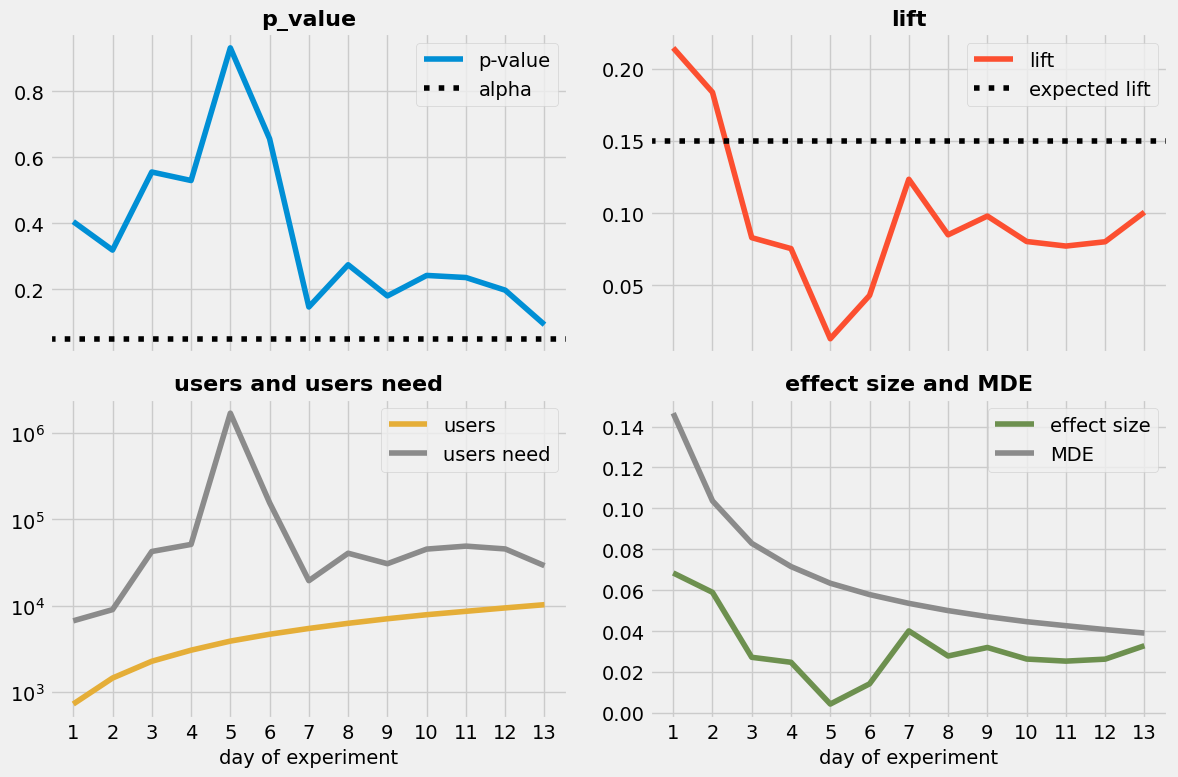

In [10]:
# вывод на экран графиков p-value, lift, users, users need, effect, size и mde
palette = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']

fig, ax = plt.subplots(nrows = 2,
                       ncols = 2,
                       figsize = (12, 8),
                       sharex = True)

ax = ax.flatten()

for i, (feat, color) in enumerate(zip(data.columns[[1, 2, 3, 5]], palette)):
    ax[i].plot(data[feat], color = color)
    ax[i].set_xticks(np.arange(1, 14), np.arange(1, 14))
    if i < 2:
        ax[i].set_title(feat, fontsize = 16, fontweight = 'bold')
    if i > 1:
        ax[i].set_xlabel('day of experiment', fontsize = 14)

ax[0].axhline(y       = ALPHA,
            linestyle = 'dotted',
            color     = 'black')

ax[1].axhline(y       = EXPECTED_LIFT,
            linestyle = 'dotted',
            color     = 'black')

ax[2].plot(data['users_need'],
           color = '#8b8b8b')

ax[3].plot(data['mde'],
           color = '#8b8b8b')

ax[2].set_yscale('log')

ax[2].set_title('users and users need',
                fontsize   = 16,
                fontweight = 'bold')

ax[3].set_title('effect size and MDE',
                fontsize   = 16,
                fontweight = 'bold')

ax[0].legend(labels = ['p-value', 'alpha'])
ax[1].legend(labels = ['lift', 'expected lift'])
ax[2].legend(labels = ['users', 'users need'])
ax[3].legend(labels = ['effect size', 'MDE'])

plt.tight_layout()
plt.show()

- **p-value**: в течение первых 5 дней эксперимента p-value рос, но затем начал снижаться; по состоянию на последний доступный день эксперимента p-value больше α 0.05 (т.е. говорить о наличии эффекта нельзя), но при этом значение не вышло на плато, поэтому если ориентироваться только p-value, останавливать эксперимент рано
- **lift**: в течение первых 5 дней эксперимента lift снижался, но затем начал расти; по состоянию на последний доступный день эксперимента наблюдаемый lift ниже ожидаемого
- **users and users need**: количество пользователей ожидаемо растет по ходу эксперимента, при этом демонстрирует линейный рост; исходя из наблюдаемого эффекта количество необходимых пользователей стремится к фактическому, т.е. целесообразно продолжать эксперимент
- **effect size и MDE**: фактический mde ожидаемо снижается по ходу эксперимента при увеличении числа участников; по состоянию на последний доступный день эксперимента наблюдаемый effect size по модулю ниже фактического mde, т.е. мы не можем быть уверены в результатах эксперимента при заданных значениях α и β, и это является дополнительным аргументом в пользу продолжения эксперимента

## Расчет времени, необходимого на проведение эксперимента



На предыдущем этапе мы рассчитали время, необходимое на проведение эксперимента, исходя из наблюдаемого lift'а. Дополнительно рассчитаем аналогичный показатель для ожидаемого lift'а на момент начала эксперимента:

In [11]:
# расчет ожидаемого эффекта и времени, необходимого на проведение эксперимента, исходя из него
expected_effect_size = proportion_effectsize(BASE_CONVERSION, BASE_CONVERSION * (1 + EXPECTED_LIFT))
expected_users_need = zt_ind_solve_power(effect_size = expected_effect_size,
                                         alpha       = ALPHA,
                                         power       = 1 - BETA) * SPLITS

Поскольку количество наблюдений демонстрирует линейный рост, спрогнозируем рост количества наблюдений на неделю вперед при помощи линейной регрессии

In [12]:
# расчет прогноза количества пользователей на месяц вперед
X = np.arange(1,14).reshape((13,1))
lr = LinearRegression().fit(X, data.users)
period_to_predict = np.arange(14, 14 + 30).reshape(30,1)
users_growth_preds = lr.predict(period_to_predict)

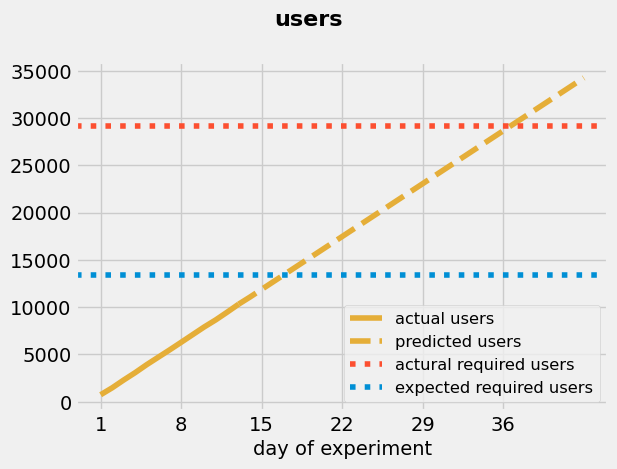

In [13]:
# вывод на экран фактического и прогнозного количества наблюдений
fig = plt.figure()

plt.plot(data.users,
         color = '#e5ae38')

plt.plot(np.arange(13, 13 + 31),
         [data.users[13]] + list(users_growth_preds),
         color     = '#e5ae38',
         linestyle = 'dashed')

plt.axhline(y         = data.iloc[-1, -1],
            linestyle = 'dotted',
            color     = '#fc4f30')

plt.axhline(y         = expected_users_need,
            linestyle = 'dotted',
            color     = '#008fd5')

plt.xticks(np.arange(1, 43, 7), np.arange(1, 43, 7))
plt.xlabel('day of experiment', fontsize = 14)

plt.legend(labels   = ['actual users', 'predicted users', 'actural required users', 'expected required users'],
           fontsize = 'small')

plt.suptitle('users',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

При условии сохранения линенйного роста числа пользователей:

- исходя из ожидаемого эффекта количество наблюдений достигнет необходимого значения на 17-й день, т.е. необходимо продолжать эксперимент еще 4 дня;
- исходя из наблюдаемого эффекта (при условии, что он сохранится), количество наблюдений достигнет необходимого значения на 37-й день, т.е. необходимо продолжать эксперимент еще две 3 с половиной недели.

## Общие выводы

В ходе работы над кейсом мы проанализировали промежуточные результаты A/B-теста для сервиса по доставке еды («спящим» пользователям отправили промокод на скидку 30% на заказ) и рассчитали время, необходимое на проведение эксперимента, исходя из ожидаемого и фактического lift'а.

**Анализ промежуточных результатов эксперимента**

- **p-value**: в течение первых 5 дней эксперимента p-value рос, но затем начал снижаться; по состоянию на последний доступный день эксперимента p-value больше α 0.05 (т.е. говорить о наличии эффекта нельзя), но при этом значение не вышло на плато, поэтому если ориентироваться только p-value, останавливать эксперимент рано
- **lift**: в течение первых 5 дней эксперимента lift снижался, но затем начал расти; по состоянию на последний доступный день эксперимента наблюдаемый lift ниже ожидаемого
- **users and users need**: количество пользователей ожидаемо растет по ходу эксперимента, при этом демонстрирует линейный рост; исходя из наблюдаемого эффекта количество необходимых пользователей стремится к фактическому, т.е. целесообразно продолжать эксперимент
- **effect size и MDE**: фактический mde ожидаемо снижается по ходу эксперимента при увеличении числа участников; по состоянию на последний доступный день эксперимента наблюдаемый effect size по модулю ниже фактического mde, т.е. мы не можем быть уверены в результатах эксперимента при заданных значениях α и β, и это является дополнительным аргументом в пользу продолжения эксперимента

**Расчет времени, необходимого на проведение эксперимента**

При условии сохранения линенйного роста числа пользователей:

- исходя из ожидаемого эффекта количество наблюдений достигнет необходимого значения на 17-й день, т.е. необходимо продолжать эксперимент еще 4 дня;
- исходя из наблюдаемого эффекта (при условии, что он сохранится), количество наблюдений достигнет необходимого значения на 37-й день, т.е. необходимо продолжать эксперимент еще две 3 с половиной недели.